#Exploratory Data Analysis of Stringer Dataset 
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

# to do list

1. custom normalization: dividing by mean value per neuron
1a. downsampling: convolve then downsample by 5
2. training validation split: withhold last 20 percent of time series for testing
3. RNN for each layer: a way to capture the dynamics inside each layer instead of capturing extra dynamics from inter-layer interactions. it will be OK to compare the different RNNs. maintain same neuron count in each layer to reduce potential bias 
4. layer weight regularization: L2 
5. early stopping , dropout?

## Loading of Stringer spontaneous data



In [ ]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [ ]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [ ]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [ ]:
# functions 

def moving_avg(array, factor = 5):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    zeros_ = np.zeros((array.shape[0], 2))
    array = np.hstack((array, zeros_))

    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
    array = np.mean(array, axis = 2)

    return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [ ]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [ ]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [ ]:
# it can be done in one loop ... 
data_ = []
for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1].values)

dataRNN = np.zeros((n_samples*9, dataSet.shape[1]-1))
for i in range(0,9):
    
    # dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]
    ## normalized by layer
    dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]/np.mean(np.asarray(data_)[i,:,:], axis = 0)

## shuffling for training purposes

#np.random.shuffle(dataRNN)

In [ ]:
#unshuffled = np.array(data_)

In [ ]:
#@title Convolutions code

# convolution moving average

# kernel_length = 50
# averaging_kernel = np.ones(kernel_length) / kernel_length

# dataRNN.shape

# avgd_dataRNN = list()

# for neuron in dataRNN:
#   avgd_dataRNN.append(np.convolve(neuron, averaging_kernel))

# avg_dataRNN = np.array(avgd_dataRNN)

# print(avg_dataRNN.shape)

In [ ]:
# @title Z Score Code 


# from scipy.stats import zscore


# neuron = 500

# scaled_all = zscore(avg_dataRNN)
# scaled_per_neuron = zscore(avg_dataRNN[neuron, :])

# scaled_per_layer = list()

# for layer in unshuffled:
#   scaled_per_layer.append(zscore(layer))

# scaled_per_layer = np.array(scaled_per_layer)



# plt.plot(avg_dataRNN[neuron, :])
# plt.plot(avg_dataRNN[2500, :])
# plt.figure()
# plt.plot(dataRNN[neuron, :])
# plt.figure()
# plt.plot(scaled_all[neuron, :])
# plt.plot(scaled_per_neuron)
# plt.figure()
# plt.plot(scaled_per_layer[0,neuron,:])


In [ ]:
# custom normalization

normed_dataRNN = list()
for neuron in dataRNN:
    normed_dataRNN.append(neuron)# / neuron.mean())
normed_dataRNN = np.array(normed_dataRNN)

# downsampling and averaging 
#avgd_normed_dataRNN = dataRNN#
avgd_normed_dataRNN = moving_avg(dataRNN, factor=2)

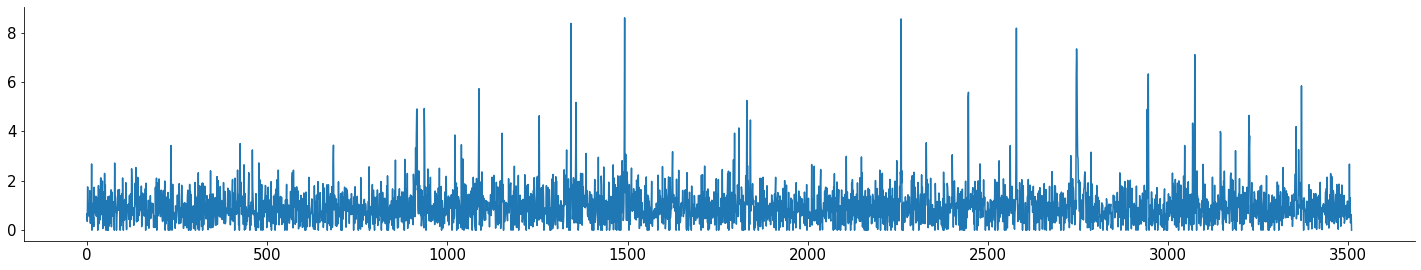

In [ ]:
plt.plot(avgd_normed_dataRNN[0,:])

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

In [ ]:
# swapping the axes to maintain consistency with seq2seq notebook in the following code - the network takes all the neurons at a time step as input, not just one neuron

# avgd_normed_dataRNN = np.swapaxes(avgd_normed_dataRNN, 0, 1)
avgd_normed_dataRNN.shape

(10179, 3510)

In [ ]:
frac = 4/5

#x1 = torch.from_numpy(dataRNN[:,:int(frac*dataRNN.shape[1])]).to(device).float().unsqueeze(0)
#x2 = torch.from_numpy(dataRNN[:,int(frac*dataRNN.shape[1]):]).to(device).float().unsqueeze(0)
#x1 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)
#x2 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)

n_neurs = 1131
# let's use n_neurs/10 latent components
ncomp = int(n_neurs/10)

x1_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)
x2_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)

x1_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)
x2_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)

NN1 = x1_train.shape[0]
NN2 = x2_train.shape[0]


In [ ]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, bidi=True):
        super(Net, self).__init__()

        # play with some of the options in the RNN!
        
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = 1, dropout = 0.,
                         bidirectional = bidi)
        """
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        
        self.mlp = nn.Sequential(
                    nn.Linear(ncomp, ncomp*5),
                    nn.Mish(),
                    nn.Dropout(),
                    nn.Linear(ncomp*5, ncomp*5),
                    nn.Mish(),
                    nn.Dropout(),
                    nn.Linear(ncomp*5, ncomp), 
                    nn.Mish())
        
        self.fc = nn.Linear(ncomp, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        #print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y, h_n = self.rnn(x)

        #print(y.shape)
        #print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y
        
        q = self.mlp(q)

        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        #print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [ ]:
# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1_train.mean(axis = (0,1))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer1 = torch.optim.Adam(net.parameters(), lr=.0001)
# optimizer2 = torch.optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 0.01, )
# optimizer3 = torch.optim.

In [ ]:
# forward check 
# net(x1)
net(x1_train)

(tensor([[[1.0162],
          [1.0078],
          [1.0047],
          ...,
          [1.0129],
          [0.9854],
          [0.9999]],
 
         [[0.9910],
          [0.9870],
          [0.9848],
          ...,
          [0.9964],
          [0.9742],
          [0.9620]],
 
         [[0.9963],
          [1.0095],
          [1.0099],
          ...,
          [0.9931],
          [1.0135],
          [0.9941]],
 
         ...,
 
         [[0.9966],
          [0.9864],
          [0.9921],
          ...,
          [1.0000],
          [1.0051],
          [0.9897]],
 
         [[1.0193],
          [1.0461],
          [1.0441],
          ...,
          [1.0202],
          [1.0221],
          [1.0148]],
 
         [[1.0161],
          [1.0223],
          [1.0108],
          ...,
          [1.0328],
          [0.9996],
          [0.9928]]], device='cuda:0', grad_fn=<PermuteBackward>),
 tensor([[[ 0.0262,  0.0173, -0.0058,  ..., -0.0190,  0.0040, -0.0143]],
 
         [[ 0.0197,  0.0872, -0.0183,

## Training 

In [ ]:
from tqdm import tqdm

In [ ]:
from sam import SAM

base_optimizer = torch.optim.Adam  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(net.parameters(), base_optimizer, lr=0.001, weight_decay = 1e-5)#, momentum=0.9)

# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

#train_save = []
#valid_save = []

niter =  5500 # 
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer.first_step(zero_grad = True)
    
    cost(net(x1_train)[0],x2_train).backward()
    
    optimizer.second_step(zero_grad=True)
    
    with torch.no_grad():
        net.eval()
        train_save.append(loss.item())
        valid_loss = cost(net(x1_valid)[0], x2_valid)
        valid_save.append(valid_loss.item())

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')

  0%|          | 1/5500 [00:00<29:37,  3.09it/s]

 iteration 0, train cost 2.6957, valid cost 2.7404


  1%|          | 51/5500 [00:15<28:24,  3.20it/s]

 iteration 50, train cost 2.0626, valid cost 2.1206


  2%|▏         | 101/5500 [00:31<28:07,  3.20it/s]

 iteration 100, train cost 1.8630, valid cost 1.9056


  3%|▎         | 151/5500 [00:46<27:45,  3.21it/s]

 iteration 150, train cost 1.7417, valid cost 1.7943


  4%|▎         | 201/5500 [01:01<27:38,  3.19it/s]

 iteration 200, train cost 1.6435, valid cost 1.7100


  5%|▍         | 251/5500 [01:17<27:20,  3.20it/s]

 iteration 250, train cost 1.5788, valid cost 1.6504


  5%|▌         | 301/5500 [01:32<26:56,  3.22it/s]

 iteration 300, train cost 1.5308, valid cost 1.6102


  6%|▋         | 351/5500 [01:47<26:40,  3.22it/s]

 iteration 350, train cost 1.4915, valid cost 1.5721


  7%|▋         | 401/5500 [02:03<26:24,  3.22it/s]

 iteration 400, train cost 1.4547, valid cost 1.5378


  8%|▊         | 451/5500 [02:18<26:02,  3.23it/s]

 iteration 450, train cost 1.4199, valid cost 1.5093


  9%|▉         | 501/5500 [02:33<25:53,  3.22it/s]

 iteration 500, train cost 1.3930, valid cost 1.4871


 10%|█         | 551/5500 [02:48<25:35,  3.22it/s]

 iteration 550, train cost 1.3702, valid cost 1.4676


 11%|█         | 601/5500 [03:04<25:23,  3.22it/s]

 iteration 600, train cost 1.3483, valid cost 1.4487


 12%|█▏        | 651/5500 [03:19<25:08,  3.21it/s]

 iteration 650, train cost 1.3302, valid cost 1.4331


 13%|█▎        | 701/5500 [03:34<24:56,  3.21it/s]

 iteration 700, train cost 1.3146, valid cost 1.4203


 14%|█▎        | 751/5500 [03:50<24:32,  3.22it/s]

 iteration 750, train cost 1.2975, valid cost 1.4017


 15%|█▍        | 801/5500 [04:05<24:19,  3.22it/s]

 iteration 800, train cost 1.2834, valid cost 1.3896


 15%|█▌        | 851/5500 [04:20<24:16,  3.19it/s]

 iteration 850, train cost 1.2712, valid cost 1.3783


 16%|█▋        | 901/5500 [04:36<23:59,  3.20it/s]

 iteration 900, train cost 1.2567, valid cost 1.3650


 17%|█▋        | 917/5500 [04:41<23:32,  3.24it/s]

In [ ]:
plt.plot(valid_save)
plt.plot(loss_save)

In [ ]:
"""
### Original training
# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

niter = 5800
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer1.step()
    optimizer1.zero_grad()
    

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')

""";  

## Validation from same neurons

In [ ]:
test, hidden = net(x1_valid)

In [ ]:
plt.plot(x2_valid[7,:,0].cpu().detach().numpy())
plt.plot(test[7,:,0].cpu().detach().numpy())

## Testing neurons from same layer

In [ ]:
test, hidden = net(torch.from_numpy(avgd_normed_dataRNN[n_neurs:2*n_neurs,:]).unsqueeze(2).to(device).float())

In [ ]:
test.shape

In [ ]:
n_n = 15
plt.plot(test[n_n,:,0].cpu().detach().numpy())
plt.plot(avgd_normed_dataRNN[n_neurs + n_n,:])

## Testing neurons from another layer (#9)

In [ ]:
test, hidden = net(torch.from_numpy(avgd_normed_dataRNN[10000:10100,:]).unsqueeze(2).to(device).float())

In [ ]:
plt.plot(test[10,:,0].cpu().detach().numpy())
plt.plot(avgd_normed_dataRNN[10010,:])

# Training 9 Networks 
Each Network corresponds to a different layer in V1

In [ ]:
# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

niter = 10000
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer1.step()
    optimizer1.zero_grad()

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')

    